In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn import preprocessing
dtype = torch.float64
device = torch.device("cuda:0")
torch.manual_seed(42)
data = pd.read_csv("NN_training_big.nn")
np.random.seed(42)

In [2]:
data = data.set_index("Unnamed: 0")

In [3]:
data.iloc[0,0]

24.0

In [4]:
data = data.reset_index()
data.head()

,Unnamed: 0,Actual Velocity,Track Section,0_x,10_x,20_x,30_x,40_x,50_x,60_x,...,2500_y,2510_y,2520_y,2530_y,2540_y,2550_y,mean_acc_y,median_y,95_acc_y,max_acc_y
0,0,24.0,0.0,0.002890,0.002176,0.004270,0.007065,0.009169,0.008229,0.006080,...,0.001342,0.001679,0.001001,0.001741,0.001173,0.001034,0.441387,0.353673,1.135934,6.148501
1,2,25.0,0.0,0.006483,0.012145,0.016721,0.014323,0.019283,0.015196,0.018086,...,0.001500,0.001161,0.001255,0.001117,0.000859,0.001176,0.435271,0.328850,1.205422,6.901017
2,5,25.0,2580.0,0.006075,0.026636,0.049570,0.035475,0.045464,0.058989,0.035533,...,0.001636,0.000910,0.001677,0.001872,0.001693,0.001617,0.492657,0.398906,1.274077,2.885397
3,6,25.0,2580.0,0.006267,0.005948,0.009482,0.013067,0.011271,0.009465,0.012031,...,0.001607,0.001065,0.001259,0.001687,0.001401,0.001769,0.452549,0.330364,1.290717,3.406660
4,7,24.0,2580.0,0.006267,0.005948,0.009482,0.013067,0.011271,0.009465,0.012031,...,0.001607,0.001065,0.001259,0.001687,0.001401,0.001769,0.452549,0.330364,1.290717,3.406660


next cell is a little confusing
we scale the acceleration data (and not the target variables, actual velocity and track section)
then we add back in the target variable speed (not looking at position in this model).
Then we split into training, test and validate datasets.

In [5]:
x = data.iloc[:,3:].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
d2 = pd.DataFrame(x_scaled)
d2["speed"] = data.iloc[:,1].values
train, validate, test = np.split(d2.sample(frac=1), [int(.6*len(d2)), int(.8*len(d2))])

In [6]:
d2.head()

,0,1,2,3,4,5,6,7,8,9,...,511,512,513,514,515,516,517,518,519,speed
0,0.012894,0.010084,0.022370,0.039810,0.067396,0.061797,0.045177,0.056379,0.103754,0.134596,...,0.049948,0.020839,0.030925,0.016744,0.018857,0.043747,0.043857,0.041497,0.021361,24.0
1,0.032390,0.059556,0.089179,0.081217,0.142221,0.114948,0.135067,0.062820,0.131166,0.124973,...,0.034443,0.026175,0.019798,0.012231,0.021470,0.043136,0.040753,0.044054,0.023981,25.0
2,0.030172,0.131468,0.265445,0.201901,0.335917,0.449037,0.265696,0.289620,0.301918,0.199964,...,0.026947,0.035032,0.033254,0.024216,0.029571,0.048867,0.049511,0.046580,0.009997,25.0
3,0.031216,0.028804,0.050335,0.074051,0.082951,0.071224,0.089734,0.085961,0.228390,0.272376,...,0.031598,0.026260,0.029963,0.020023,0.032347,0.044862,0.040943,0.047193,0.011812,25.0
4,0.031216,0.028804,0.050335,0.074051,0.082951,0.071224,0.089734,0.085961,0.228390,0.272376,...,0.031598,0.026260,0.029963,0.020023,0.032347,0.044862,0.040943,0.047193,0.011812,24.0


In [7]:
y_tr = torch.from_numpy(train.iloc[:,-1].to_numpy())
y_tr = y_tr.view(y_tr.shape[0], 1)
y_te = torch.from_numpy(test.iloc[:,-1].to_numpy())
y_te = y_te.view(y_te.shape[0], 1)
y_va = torch.from_numpy(validate.iloc[:,-1].to_numpy())
y_va = y_va.view(y_va.shape[0], 1)

In [8]:
x_tr = torch.from_numpy(train.iloc[:,:-1].to_numpy())
x_te = torch.from_numpy(test.iloc[:,:-1].to_numpy())
x_va = torch.from_numpy(validate.iloc[:,:-1].to_numpy())

In [9]:
print(x_tr.shape, y_tr.shape)

torch.Size([10008, 520]) torch.Size([10008, 1])


In [10]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,511,512,513,514,515,516,517,518,519,speed
485,0.013801,0.044892,0.113802,0.178376,0.301623,0.167224,0.126587,0.158301,0.232646,0.195600,...,0.044672,0.026107,0.024301,0.036761,0.026343,0.083705,0.076614,0.086767,0.029065,38.0
8398,0.028837,0.035168,0.070129,0.082381,0.088652,0.115970,0.126023,0.035847,0.045223,0.043046,...,0.045091,0.040078,0.027772,0.023096,0.038960,0.120192,0.118210,0.115538,0.049316,66.0
2571,0.019712,0.019582,0.081202,0.086935,0.155120,0.114698,0.189383,0.144992,0.103995,0.057024,...,0.140108,0.090366,0.146999,0.095440,0.141284,0.304634,0.217707,0.381386,0.192331,79.0
14774,0.019306,0.028080,0.049760,0.065020,0.097671,0.051779,0.068423,0.030853,0.034626,0.019773,...,0.184284,0.079770,0.063068,0.063960,0.041093,0.091007,0.093789,0.085975,0.025356,65.0
5396,0.037723,0.081350,0.116759,0.157689,0.330517,0.237989,0.301501,0.269261,0.267445,0.095816,...,0.086822,0.069117,0.070014,0.076017,0.087131,0.246878,0.253661,0.226441,0.093765,79.0


In [11]:
x_tr[0]

tensor([0.0138, 0.0449, 0.1138, 0.1784, 0.3016, 0.1672, 0.1266, 0.1583, 0.2326,
        0.1956, 0.2777, 0.1348, 0.2416, 0.1878, 0.1444, 0.1688, 0.1344, 0.1670,
        0.1325, 0.0792, 0.1016, 0.1159, 0.1290, 0.0804, 0.1102, 0.0791, 0.1411,
        0.1004, 0.1436, 0.0731, 0.0940, 0.0458, 0.0695, 0.1099, 0.0930, 0.0743,
        0.0462, 0.0637, 0.0516, 0.0362, 0.0737, 0.0517, 0.0508, 0.0215, 0.0237,
        0.0380, 0.0238, 0.0174, 0.0266, 0.0300, 0.0245, 0.0259, 0.0185, 0.0717,
        0.0664, 0.0589, 0.0899, 0.1092, 0.0774, 0.0780, 0.0871, 0.0531, 0.1240,
        0.0776, 0.0798, 0.0686, 0.0476, 0.0323, 0.0354, 0.0381, 0.0414, 0.0378,
        0.0357, 0.0278, 0.0237, 0.0274, 0.0280, 0.0304, 0.0609, 0.0374, 0.0515,
        0.0381, 0.0621, 0.0314, 0.0348, 0.0482, 0.0406, 0.0341, 0.0341, 0.0213,
        0.0298, 0.0256, 0.0533, 0.0441, 0.0402, 0.0315, 0.0413, 0.0222, 0.0235,
        0.0230, 0.0149, 0.0272, 0.0220, 0.0233, 0.0316, 0.0269, 0.0364, 0.0287,
        0.0311, 0.0381, 0.0357, 0.0274, 

In [12]:
x_tr = x_tr.float()
y_tr = y_tr.float()
x_tr.shape

torch.Size([10008, 520])

In [13]:
x3d = x_tr.view(x_tr.shape[0],1,x_tr.shape[1])
x3d.shape

torch.Size([10008, 1, 520])

In [14]:
x_sq = torch.flatten(x3d, start_dim = 1)
x_sq.shape

torch.Size([10008, 520])

In [15]:
x_sq[0,-1] == x3d[0,0,-1]

tensor(True)

In [16]:
x3d[0,0,0:10]

tensor([0.0138, 0.0449, 0.1138, 0.1784, 0.3016, 0.1672, 0.1266, 0.1583, 0.2326,
        0.1956])

In [17]:
x_sq[0,0:10]

tensor([0.0138, 0.0449, 0.1138, 0.1784, 0.3016, 0.1672, 0.1266, 0.1583, 0.2326,
        0.1956])

In [18]:
m = torch.nn.Conv1d(1,1,5)

In [19]:
output = m(x3d)
output.shape

torch.Size([10008, 1, 516])

In [20]:
x_tr = x_tr.cuda()
y_tr = y_tr.cuda()

In [21]:
x_te = x_te.float().cuda()
y_te = y_te.float().cuda()

In [22]:
x_va = x_te.float().cuda()
y_va = y_te.float().cuda()

In [23]:
l_rate = 1e-6

input_dim, hiden_dim, h2, h3, h4, h5, h6, output_dim = 520, 520, 520, 125, 125, 30, 30, y_tr.shape[1]
model = torch.nn.Sequential(
#     torch.nn.Conv1d(1,1,5),
#     torch.nn.ReLU(),
#     torch.nn.Flatten(start_dim =1),
    torch.nn.Linear(input_dim, hiden_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(hiden_dim, h2),
    torch.nn.ReLU(),
#     torch.nn.Linear(h2, h3),
#     torch.nn.ReLU(),
#     torch.nn.Linear(h3, h4),
#     torch.nn.ReLU(),
#     torch.nn.Linear(h4, h5),
#     torch.nn.ReLU(),
#     torch.nn.Linear(h5, h6),
#     torch.nn.ReLU(),
    torch.nn.Linear(h2, output_dim),
)
model.cuda()
loss_fn = torch.nn.MSELoss(reduction="sum")
losses_train = []
losses_test = []
times = []

In [24]:
x_tr_3d = x_tr.view(x_tr.shape[0], 1, x_tr.shape[1])
x_te_3d = x_te.view(x_te.shape[0], 1, x_te.shape[1])
x_va_3d = x_va.view(x_va.shape[0], 1, x_va.shape[1])
losses_train = []
losses_test = []
times = []

In [25]:
x_tr_3d.shape

torch.Size([10008, 1, 520])

training error:     99  3316382.500
test error:         99  1068618.500
training error:    199  696240.000
test error:        199  263634.500
training error:    299  345479.281
test error:        299  155503.578
training error:    399  232469.719
test error:        399  116268.906
training error:    499  182086.859
test error:        499  97746.453
training error:    599  155353.766
test error:        599  87901.156
training error:    699  137221.562
test error:        699  81897.047
Epoch   755: reducing learning rate of group 0 to 2.0000e-04.
training error:    799  127179.828
test error:        799  78446.711
training error:    899  124534.500
test error:        899  77589.953
training error:    999  121861.273
test error:        999  76752.773
training error:   1099  119120.242
test error:       1099  75908.914
training error:   1199  116308.141
test error:       1199  75048.172
training error:   1299  113429.844
test error:       1299  74177.602
training error:   1399  110500.789


<AxesSubplot:xlabel='time', ylabel='test_l'>

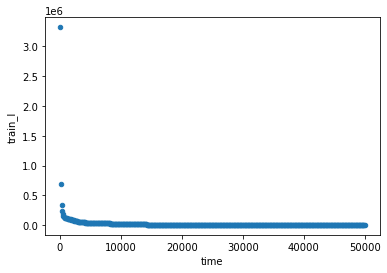

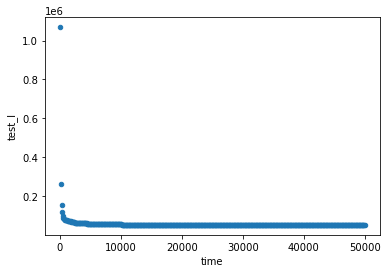

In [26]:
# scheduler = optim.X(optimizer,...)      # create lr scheduler
# scheduler.step()                        # update lr at start of epoch
# optim.lr_scheduler.X                    # where X is LambdaLR, StepLR, MultiStepLR,
              # ExponentialLR or ReduceLROnPLateau
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=10, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
for t in range(50000):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x_tr)

    # Compute and print loss.
    loss = loss_fn(y_pred, y_tr)
    if t % 100 == 99:
        print("{:16}{:6}  {:5.3f}".format("training error:", t, loss.item()))
        y_test = model(x_te)
        loss_te = loss_fn(y_test, y_te)
        print("{:16}{:6}  {:5.3f}".format("test error:", t, loss_te.item()))
    if t % 100 == 99:
#         print("{:16}{:6}  {:5.3f}".format("training error:", t, loss.item()))
        y_test = model(x_te)
        loss_te = loss_fn(y_test, y_te)
#         print("{:16}{:6}  {:5.3f}".format("test error:", t, loss_te.item()))
        losses_train.append(loss.item())
        losses_test.append(loss_te.item())
        times.append(t)

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()
    scheduler.step(loss)
stats = pd.DataFrame({"train_l":losses_train, "test_l":losses_test, "time":times})
# stats.plot(x="time", y=["train_l", "test_l"], kind="scatter")
stats.plot(x="time", y="train_l", kind="scatter")
stats.plot(x="time", y="test_l", kind="scatter")

<AxesSubplot:xlabel='time', ylabel='test_l'>

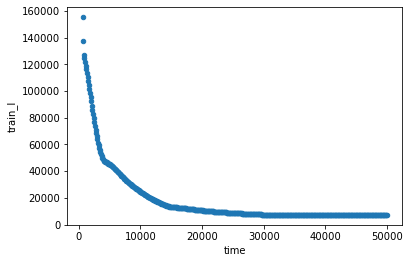

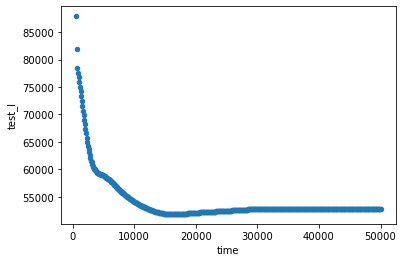

In [27]:
stats.iloc[5:,:].plot(x="time", y="train_l", kind="scatter")
stats.iloc[5:,:].plot(x="time", y="test_l", kind="scatter")

<AxesSubplot:xlabel='time', ylabel='test_l'>

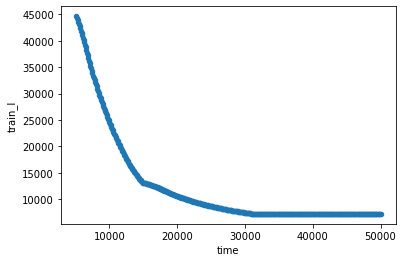

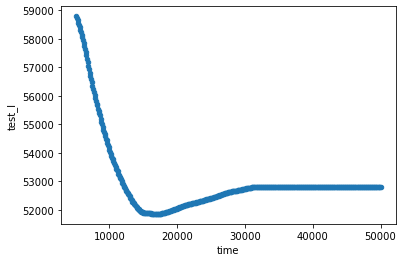

In [28]:
stats.iloc[50:,:].plot(x="time", y="train_l", kind="scatter")
stats.iloc[50:,:].plot(x="time", y="test_l", kind="scatter")

In [29]:
from ray import tune

In [30]:
# l_rate = 1e-5

In [31]:
model2 = torch.nn.Sequential(
#     torch.nn.Conv1d(1,1,5),
#     torch.nn.ReLU(),
#     torch.nn.Flatten(start_dim =1),
    torch.nn.Linear(input_dim, hiden_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(hiden_dim, h2),
    torch.nn.ReLU(),
    torch.nn.Linear(h2, h2),
    torch.nn.ReLU(),
#     torch.nn.Linear(h3, h4),
#     torch.nn.ReLU(),
#     torch.nn.Linear(h4, h5),
#     torch.nn.ReLU(),
#     torch.nn.Linear(h5, h6),
#     torch.nn.ReLU(),
    torch.nn.Linear(h2, output_dim),
)
model2.cuda()
loss_fn = torch.nn.MSELoss(reduction="sum")
losses_train2 = []
losses_test2 = []
times2 = []
lrs2 = []

In [33]:
# scheduler = optim.X(optimizer,...)      # create lr scheduler
# scheduler.step()                        # update lr at start of epoch
# optim.lr_scheduler.X                    # where X is LambdaLR, StepLR, MultiStepLR,
# ExponentialLR or ReduceLROnPLateau
learning_rate = 1e-2
optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate)
scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer2, mode='min', factor=0.2, patience=10, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
for t in range(20000):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model2(x_tr)

    # Compute and print loss.
    loss = loss_fn(y_pred, y_tr)
    if t % 1000 == 99:
        print("{:16}{:6}  {:5.3f}".format("training error:", t, loss.item()))
        y_test = model2(x_te)
        loss_te = loss_fn(y_test, y_te)
        print("{:16}{:6}  {:5.3f}".format("test error:", t, loss_te.item()))
    if t % 100 == 99:
#         print("{:16}{:6}  {:5.3f}".format("training error:", t, loss.item()))
        y_test = model2(x_te)
        loss_te = loss_fn(y_test, y_te)
#         print("{:16}{:6}  {:5.3f}".format("test error:", t, loss_te.item()))
        losses_train2.append(loss.item())
        losses_test2.append(loss_te.item())
        times2.append(t)
        lrs2.append(scheduler2._last_lr)

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer2.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer2.step()
    scheduler2.step(loss)
stats2 = pd.DataFrame({"train_l":losses_train2, "test_l":losses_test2, "time":times2, "learning":lrs2})
# stats.plot(x="time", y=["train_l", "test_l"], kind="scatter")
stats2.plot(x="time", y="train_l", kind="scatter")
stats2.plot(x="time", y="test_l", kind="scatter")
stats2.plot(x="time", y="learning", kind="scatter")

Epoch    12: reducing learning rate of group 0 to 2.0000e-03.
Epoch    23: reducing learning rate of group 0 to 4.0000e-04.
Epoch    34: reducing learning rate of group 0 to 8.0000e-05.
Epoch    45: reducing learning rate of group 0 to 1.6000e-05.
Epoch    56: reducing learning rate of group 0 to 3.2000e-06.
Epoch    67: reducing learning rate of group 0 to 6.4000e-07.
Epoch    78: reducing learning rate of group 0 to 1.2800e-07.
Epoch    89: reducing learning rate of group 0 to 2.5600e-08.
training error:     99  797455.438
test error:         99  275753.062
Epoch   100: reducing learning rate of group 0 to 5.1200e-09.
training error:   1099  797298.375
test error:       1099  275708.500
training error:   2099  797034.438
test error:       2099  275634.188
training error:   3099  796725.375
test error:       3099  275547.469
training error:   4099  796390.000
test error:       4099  275453.375
training error:   5099  796043.875
test error:       5099  275356.188
training error:   6099

ValueError: arrays must all be same length

ValueError: setting an array element with a sequence.

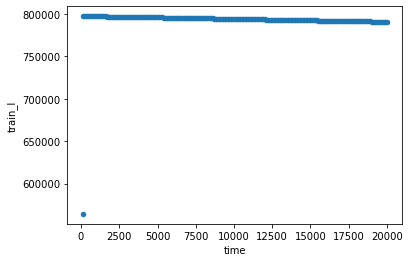

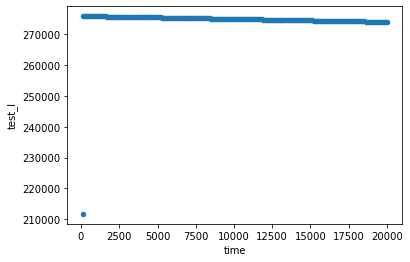

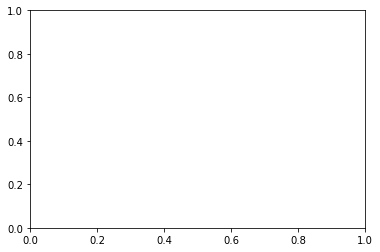

In [37]:
lrs2.append(0)
stats2 = pd.DataFrame({"train_l":losses_train2, "test_l":losses_test2, "time":times2, "learning":lrs2})
# stats.plot(x="time", y=["train_l", "test_l"], kind="scatter")
stats2.plot(x="time", y="train_l", kind="scatter")
stats2.plot(x="time", y="test_l", kind="scatter")
stats2.plot(x="time", y="learning", kind="scatter")

In [47]:
# input_dim, hiden_dim, h2, h3, h4, h5, h6, output_dim = 520, 520, 520, 125, 125, 30, 30, y_tr.shape[1]
model3 = torch.nn.Sequential(
#     torch.nn.Conv1d(1,1,5),
#     torch.nn.ReLU(),
#     torch.nn.Flatten(start_dim =1),
    torch.nn.Linear(input_dim, hiden_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(hiden_dim, h6),
    torch.nn.ReLU(),
    torch.nn.Linear(h6, h6),
    torch.nn.ReLU(),
#     torch.nn.Linear(h3, h4),
#     torch.nn.ReLU(),
#     torch.nn.Linear(h4, h5),
#     torch.nn.ReLU(),
#     torch.nn.Linear(h5, h6),
#     torch.nn.ReLU(),
    torch.nn.Linear(h6, output_dim),
)
model3.cuda()
loss_fn = torch.nn.MSELoss(reduction="sum")
losses_train3 = []
losses_test3 = []
times3 = []
lrs3 = []

Epoch    58: reducing learning rate of group 0 to 2.0000e-04.
training error:     99  5693912.000
test error:         99  1818450.000
training error:   1099  464415.219
test error:       1099  196370.359
training error:   2099  110885.625
test error:       2099  77021.062
training error:   3099  61880.559
test error:       3099  64418.805
Epoch  3971: reducing learning rate of group 0 to 4.0000e-05.
training error:   4099  42218.492
test error:       4099  60060.199
training error:   5099  38378.633
test error:       5099  59241.094
training error:   6099  33582.375
test error:       6099  58174.711
training error:   7099  28341.410
test error:       7099  57173.473
training error:   8099  24225.566
test error:       8099  56238.984
training error:   9099  21094.367
test error:       9099  55843.078
training error:  10099  18596.953
test error:      10099  55585.570
training error:  11099  16585.523
test error:      11099  55334.320
training error:  12099  14939.441
test error:      12

<AxesSubplot:xlabel='time', ylabel='lr'>

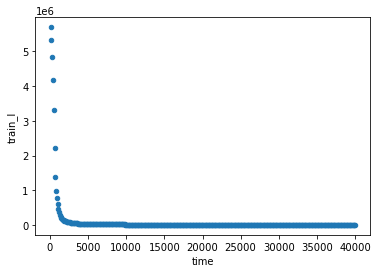

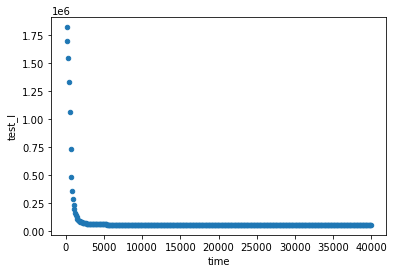

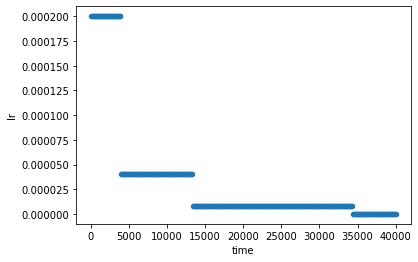

In [48]:
# scheduler = optim.X(optimizer,...)      # create lr scheduler
# scheduler.step()                        # update lr at start of epoch
# optim.lr_scheduler.X                    # where X is LambdaLR, StepLR, MultiStepLR,
              # ExponentialLR or ReduceLROnPLateau
learning_rate = 1e-3
optimizer3 = torch.optim.Adam(model3.parameters(), lr=learning_rate)
scheduler3 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer3, mode='min', factor=0.2, patience=10, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
for t in range(40000):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model3(x_tr)

    # Compute and print loss.
    loss = loss_fn(y_pred, y_tr)
    if t % 1000 == 99:
        print("{:16}{:6}  {:5.3f}".format("training error:", t, loss.item()))
        y_test = model3(x_te)
        loss_te = loss_fn(y_test, y_te)
        print("{:16}{:6}  {:5.3f}".format("test error:", t, loss_te.item()))
    if t % 100 == 99:
#         print("{:16}{:6}  {:5.3f}".format("training error:", t, loss.item()))
        y_test = model3(x_te)
        loss_te = loss_fn(y_test, y_te)
#         print("{:16}{:6}  {:5.3f}".format("test error:", t, loss_te.item()))
        losses_train3.append(loss.item())
        losses_test3.append(loss_te.item())
        times3.append(t)
        lrs3.append(scheduler3._last_lr[0])

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer3.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    scheduler3.step(loss)
    optimizer3.step()
    
stats3 = pd.DataFrame({"train_l":losses_train3, "test_l":losses_test3, "time":times3, "lr":lrs3})
# stats.plot(x="time", y=["train_l", "test_l"], kind="scatter")
stats3.plot(x="time", y="train_l", kind="scatter")
stats3.plot(x="time", y="test_l", kind="scatter")
stats3.plot(x="time", y="lr", kind="scatter")

<AxesSubplot:xlabel='time', ylabel='lr'>

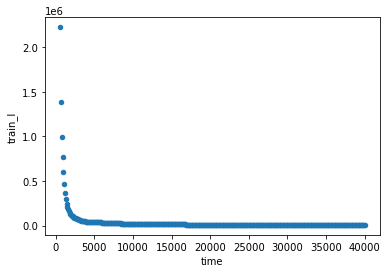

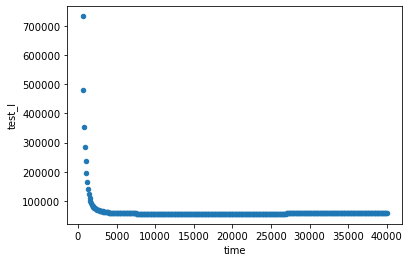

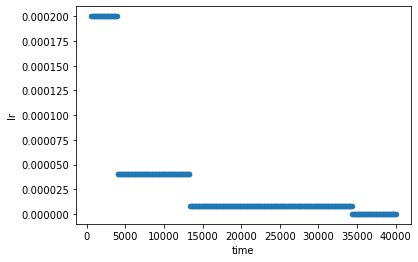

In [49]:
stats3.iloc[5:,:].plot(x="time", y="train_l", kind="scatter")
stats3.iloc[5:,:].plot(x="time", y="test_l", kind="scatter")
stats3.iloc[5:,:].plot(x="time", y="lr", kind="scatter")

<AxesSubplot:xlabel='time', ylabel='lr'>

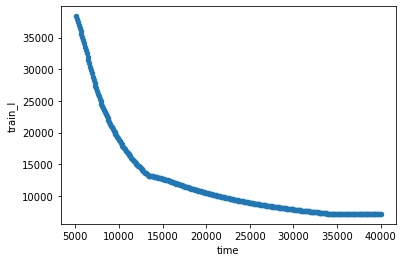

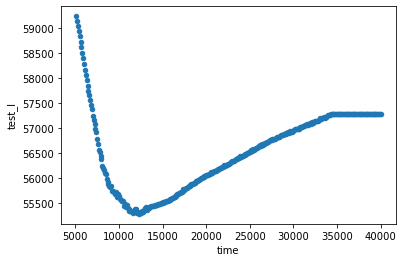

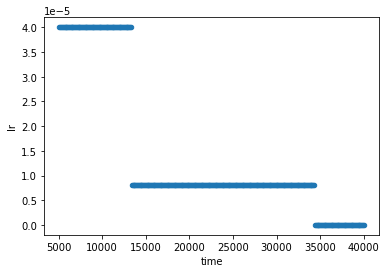

In [50]:
stats3.iloc[50:,:].plot(x="time", y="train_l", kind="scatter")
stats3.iloc[50:,:].plot(x="time", y="test_l", kind="scatter")
stats3.iloc[50:,:].plot(x="time", y="lr", kind="scatter")

In [45]:
type(lrs3[0])

list

In [46]:
lrs3[0]

[4e-05]

In [42]:
# input_dim, hiden_dim, h2, h3, h4, h5, h6, output_dim = 520, 520, 520, 125, 125, 30, 30, y_tr.shape[1]
model4 = torch.nn.Sequential(
#     torch.nn.Conv1d(1,1,5),
#     torch.nn.ReLU(),
#     torch.nn.Flatten(start_dim =1),
    torch.nn.Linear(input_dim, hiden_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(hiden_dim, h6),
    torch.nn.ReLU(),
    torch.nn.Linear(h6, h6),
    torch.nn.ReLU(),
#     torch.nn.Linear(h3, h4),
#     torch.nn.ReLU(),
#     torch.nn.Linear(h4, h5),
#     torch.nn.ReLU(),
#     torch.nn.Linear(h5, h6),
#     torch.nn.ReLU(),
    torch.nn.Linear(h6, output_dim),
)
model4.cuda()
loss_fn = torch.nn.MSELoss(reduction="sum")
losses_train4 = []
losses_test4 = []
times4 = []
lrs4 = []

In [43]:
# scheduler = optim.X(optimizer,...)      # create lr scheduler
# scheduler.step()                        # update lr at start of epoch
# optim.lr_scheduler.X                    # where X is LambdaLR, StepLR, MultiStepLR,
              # ExponentialLR or ReduceLROnPLateau
learning_rate = 1e-4
optimizer4 = torch.optim.SGD(model4.parameters(), lr=learning_rate)
scheduler4 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer4, mode='min', factor=0.2, patience=10, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
for t in range(20000):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model4(x_tr)

    # Compute and print loss.
    loss = loss_fn(y_pred, y_tr)
    if t % 1000 == 99:
        print("{:16}{:6}  {:5.3f}".format("training error:", t, loss.item()))
        y_test = model4(x_te)
        loss_te = loss_fn(y_test, y_te)
        print("{:16}{:6}  {:5.3f}".format("test error:", t, loss_te.item()))
    if t % 100 == 99:
#         print("{:16}{:6}  {:5.3f}".format("training error:", t, loss.item()))
        y_test = model4(x_te)
        loss_te = loss_fn(y_test, y_te)
#         print("{:16}{:6}  {:5.3f}".format("test error:", t, loss_te.item()))
        losses_train4.append(loss.item())
        losses_test4.append(loss_te.item())
        times4.append(t)
        lrs4.append(scheduler4._last_lr)

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer4.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    scheduler4.step(loss)
    optimizer4.step()
    
stats4 = pd.DataFrame({"train_l":losses_train4, "test_l":losses_test4, "time":times4, "lr":lrs4})
# stats.plot(x="time", y=["train_l", "test_l"], kind="scatter")
stats4.plot(x="time", y="train_l", kind="scatter")
stats4.plot(x="time", y="test_l", kind="scatter")
stats4.plot(x="time", y="test_l", kind="scatter")

Epoch    12: reducing learning rate of group 0 to 2.0000e-05.
Epoch    23: reducing learning rate of group 0 to 4.0000e-06.
Epoch    34: reducing learning rate of group 0 to 8.0000e-07.
Epoch    45: reducing learning rate of group 0 to 1.6000e-07.
Epoch    56: reducing learning rate of group 0 to 3.2000e-08.
Epoch    67: reducing learning rate of group 0 to 6.4000e-09.
training error:     99    nan
test error:         99    nan


KeyboardInterrupt: 

In [ ]:
type(optimizer4)

In [ ]:
vars(scheduler4)

In [ ]:

# for t in range(500):
# #     y_pred = model(xc).to(device)
#     y_pred = model(x_tr)
    
# #     y_c_pred = y_pred.to(dev)
#     loss = loss_fn(y_pred, y_tr)
    
#     if t % 1000 == 99:
#         print("{:16}{:6}   {:5.3}".format("training error:", t, loss.item()))
#         y_test = model(x_te)
#         loss_te = loss_fn(y_test, y_te)
#         print("{:16}{:6}  {:5.3}".format("test error:", t, loss_te.item()))
#     if t % 100 == 1:
# #         print("training error:", t, loss.item())
#         y_test = model(x_te)
#         loss_te = loss_fn(y_test, y_te)
# #         print("test error:", t, loss_te.item())
#         losses_train.append(loss.item())
#         losses_test.append(loss_te.item())
#         times.append(t)
#     model.zero_grad()
#     loss.backward()
#     with torch.no_grad():
#         for param in model.parameters():
#             param -= l_rate * param.grad

In [ ]:
# stats = pd.DataFrame({"train_l":losses_train, "test_l":losses_test, "time":times})
# # stats.plot(x="time", y=["train_l", "test_l"], kind="scatter")
# stats.plot(x="time", y="train_l", kind="scatter")
# stats.plot(x="time", y="test_l", kind="scatter")

to do:
    Randomize the order of the input data
    training/test set split
    optimise architecture
    test by plotting predicted speeds of other runs
    investigate 1d convolution layer
    print the validation set score with loss
    
    Build alternate model using raw acceleration data (down sample data) - investigate embedding/embedding layer

In [ ]:
# checkpoint = {'input_size': xc.shape[1],
#               'output_size': yc.shape[1],
#               "model_dets": model,
#               'state_dict': model.state_dict()}

# torch.save(checkpoint, 'checkpoint.pth')

In [ ]:
model

In [ ]:
df1 = pd.read_csv("01-08-19-V118_ch1.big" , index_col = 0)
df2 = pd.read_csv("01-08-19-V118_ch2.big" , index_col = 0)

In [ ]:
df1 = df1.reset_index()
df2 = df2.reset_index()

In [ ]:
df = pd.merge(df1, df2, how = "outer", on = "index")
df.head()

In [ ]:
x_ch = torch.from_numpy(min_max_scaler.transform(df.iloc[:,1:].values))
x_ch[0,0]

In [ ]:
x_ch = x_ch.float()
x_ch[0,0]

In [ ]:
x_ch = x_ch.to(device)
x_ch[0,0]

In [ ]:
x_ch.device

In [ ]:
x_ch.shape

In [ ]:
x_ch_3d = x_ch.view(x_ch.shape[0], 1, x_ch.shape[1])
x_ch_3d.shape

In [ ]:
y_ch = model(x_ch_3d)

In [ ]:
y_ch.shape

In [ ]:
ch_np = y_ch.cpu().detach().numpy()
type(ch_np)

In [ ]:
ch_np.shape

In [ ]:
df4 = pd.DataFrame(min_max_scaler.fit_transform(df.iloc[:,1:].values))

In [ ]:
df4["speed"] = ch_np

In [ ]:
df4.head()

In [ ]:
import seaborn as sb
import matplotlib.pyplot as plt

In [ ]:
df4.plot("speed")

In [ ]:
plotdf = df4.reset_index()

In [ ]:
plotdf.head()

In [ ]:
plt.figure(figsize= (30, 30))
g = sb.scatterplot(x = "index", y = "speed", data = plotdf, alpha = 0.2, color ="b")
g = sb.scatterplot(x = "index", y = data.iloc[:,-2], data = plotdf, alpha = 0.2, color ="r")

In [ ]:
plt.figure(figsize= (30, 30))
sb.lineplot(x = "index", y = "speed", data = plotdf.iloc[0:1000,:], color ="b")
# sb.lineplot(x = "index", y = "speed", data = plotdf.iloc[0:1000,:], alpha = 0.2, color ="b")

In [ ]:
plt.figure(figsize= (30, 30))
g = sb.lineplot(x = "index", y = "speed", data = plotdf, alpha = 0.2, color ="b")
g = sb.lineplot(x = "index", y = data.iloc[:,-2], data = plotdf, alpha = 0.2, color ="r")